# 전이학습(Transfer Learning) 실습 노트북 (주석 강화 버전)

이 노트북은 **PyTorch + torchvision의 ResNet18**을 활용하여, 작은 이미지 분류 데이터(예: 개미/벌)에서 전이학습을 수행하는 전형적인 흐름을 담고 있습니다.

## 노트북 구성(큰 흐름)
1. 라이브러리 로드 및 환경 설정
2. 데이터 변환(transform) 정의 및 DataLoader 구성
3. 샘플 배치 시각화
4. 학습 루프(train/val) 함수 정의
5. (A) **Fine-tuning**: 전체 파라미터를 학습(FC 교체 후 전체 업데이트)
6. (B) **Feature Extraction**: 백본은 고정(freeze)하고 마지막 FC만 학습
7. 검증 샘플/단일 이미지에 대한 예측 시각화

## 실행 전 확인
- `data_dir` 경로에 데이터가 있어야 합니다. 일반적으로 다음과 같은 구조를 기대합니다.
  - `hymenoptera_data/train/<class_name>/*`
  - `hymenoptera_data/val/<class_name>/*`
- 일부 셀에는 `...`가 포함되어 있을 수 있는데, 이는 **코드 일부가 생략**되었다는 신호입니다(학습 루프/시각화 루프가 완전하지 않을 수 있음).

## 주석 읽는 법
- 각 코드 셀 상단에 `목적/입력/출력/실행 전제/주의/권장 실행 순서` 형태로 주석을 추가했습니다.


In [2]:
# =============================================================
# [셀 설명] 라이브러리 임포트 및 환경 설정
# -------------------------------------------------------------
# - 목적: 전이학습 실습에 필요한 패키지(torch/torchvision 등)를 임포트하고, cudnn 및 matplotlib 설정을 초기화합니다.
# - 입력: (없음)
# - 출력: 모듈 로드 완료, cudnn/plt 설정 적용
# - 실행 전제: Colab/Python 환경에서 torch, torchvision이 설치되어 있어야 합니다.
# - 주의: GPU 사용 시 cudnn.benchmark=True는 속도에 유리하지만 입력 크기가 자주 바뀌면 비효율적일 수 있습니다.; plt.ion()은 대화형 플로팅(셀 실행 중 그림 업데이트)을 켭니다.
# - 권장 실행 순서: (1)
# =============================================================

# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # 대화형 모드

In [3]:
# =============================================================
# [셀 설명] 데이터 증강/정규화 및 DataLoader 구성
# -------------------------------------------------------------
# - 목적: train/val 변환(transform)을 정의하고, ImageFolder로 데이터셋을 로드한 뒤 DataLoader를 구성합니다. 또한 학습 디바이스(CPU/GPU)를 결정합니다.
# - 입력: data_dir(학습/검증 데이터 폴더 경로); data_transforms(train/val 변환 파이프라인)
# - 출력: image_datasets(train/val); dataloaders(train/val); dataset_sizes; class_names; device
# - 실행 전제: data_dir에 train/val 폴더가 존재해야 합니다.; 각 폴더 안에 클래스별 하위 폴더 구조가 있어야 합니다(ImageFolder 규칙).
# - 주의: 이 셀에 `...`가 포함되어 있으면 코드 일부가 생략된 상태일 수 있습니다. 실제 실행 시 생략 구간을 복원해야 할 수 있습니다.; Normalize의 평균/표준편차는 ImageNet 사전학습 모델과 맞추기 위한 관례입니다.
# - 권장 실행 순서: (2)
# =============================================================

# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/0-ㄱ-CODEIT(2025)/deep/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# CUDA 또는 MPS, MTIA, XPU 와 같은 `가속기(accelerator) <https://pytorch.org/docs/stable/torch.html#accelerators>`__ 에서 모델을 학습할 수 있도록 합니다.
# 현재 사용 가능한 가속기가 있다면 사용하고, 그렇지 않으면 CPU를 사용합니다.
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


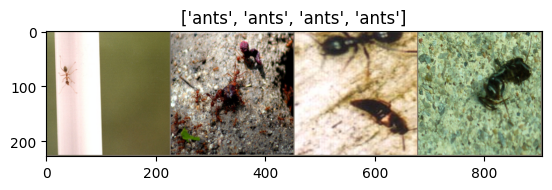

In [4]:
# =============================================================
# [셀 설명] 시각화 유틸리티(imshow) 및 배치 샘플 확인
# -------------------------------------------------------------
# - 목적: 정규화된 텐서를 사람이 보는 이미지로 역정규화하여 표시하고, 학습 배치 일부를 그리드로 확인합니다.
# - 입력: dataloaders['train']에서 배치(inputs, classes); class_names
# - 출력: 샘플 이미지 그리드 플롯(시각화)
# - 실행 전제: 데이터 로드 셀이 먼저 실행되어 dataloaders/class_names가 생성되어 있어야 합니다.
# - 주의: plt.pause는 노트북에서 그림 갱신을 위해 필요한 경우가 있습니다.; 입력 텐서는 (C,H,W) 형태이므로 transpose로 (H,W,C)로 변환합니다.
# - 권장 실행 순서: (3)
# =============================================================

def imshow(inp, title=None):
    """tensor를 입력받아 일반적인 이미지로 보여줍니다."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
# =============================================================
# [셀 설명] 학습 루프(train_model) 함수 정의
# -------------------------------------------------------------
# - 목적: train/val 단계가 포함된 학습 루프를 함수로 정의합니다. 에폭별 손실/정확도를 추적하고, 최고 검증 정확도의 파라미터를 저장/복원합니다.
# - 입력: model; criterion(손실함수); optimizer; scheduler; num_epochs
# - 출력: 학습 완료된 model(최고 val acc 파라미터로 복원)
# - 실행 전제: dataloaders, dataset_sizes, device 등이 앞 셀에서 정의되어 있어야 합니다.
# - 주의: 이 셀에 `...`가 포함되어 있으면 핵심 학습 로직(phase 루프/손실 계산/역전파 등)이 생략되었을 수 있습니다.; TemporaryDirectory는 세션 종료 시 자동 정리되므로, 영구 저장이 필요하면 Drive 경로로 체크포인트를 저장하세요.
# - 권장 실행 순서: (4)
# =============================================================

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # 모델을 학습 모드로 설정
                else:
                    model.eval()   # 모델을 평가 모드로 설정

                running_loss = 0.0
                running_corrects = 0

                # 데이터를 반복
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # 매개변수 경사도를 0으로 설정
                    optimizer.zero_grad()

                    # 순전파
                    # 학습 시에만 연산 기록을 추적
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # 학습 단계인 경우 역전파 + 최적화
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # 통계
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # 모델을 깊은 복사(deep copy)함
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # 가장 나은 모델 가중치를 불러오기
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [6]:
# =============================================================
# [셀 설명] 검증 데이터 예측 시각화(visualize_model) 함수 정의
# -------------------------------------------------------------
# - 목적: 학습된 모델이 val 데이터에서 어떻게 예측하는지 일부 이미지를 뽑아 시각화합니다.
# - 입력: model; dataloaders['val']; class_names; imshow
# - 출력: 예측 결과가 제목으로 표시된 이미지 플롯
# - 실행 전제: imshow 함수 및 dataloaders/class_names가 정의되어 있어야 합니다.
# - 주의: 이 셀에도 `...`가 있다면 반복/시각화 일부가 생략되었을 수 있습니다.; model.eval()/train() 모드 전환을 통해 드롭아웃/배치정규화 동작을 올바르게 유지합니다.
# - 권장 실행 순서: (5)
# =============================================================

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
# =============================================================
# [셀 설명] Fine-tuning용 모델 구성(ResNet18 + FC 교체)
# -------------------------------------------------------------
# - 목적: ImageNet 사전학습 ResNet18을 불러오고, 최종 분류기(FC)를 2클래스 출력으로 교체한 뒤 학습 설정을 준비합니다.
# - 입력: 사전학습 가중치(IMAGENET1K_V1); 클래스 수=2
# - 출력: model_ft; criterion; optimizer_ft; exp_lr_scheduler
# - 실행 전제: device 설정이 이미 끝나 있어야 합니다.; 사전학습 가중치 다운로드가 필요할 수 있습니다(네트워크 제한 시 캐시 필요).
# - 주의: 클래스 수가 2가 아니라면 `nn.Linear(num_ftrs, len(class_names))` 형태로 일반화하세요.; SGD lr/momentum 및 scheduler 파라미터는 데이터/배치 크기에 따라 조정이 필요합니다.
# - 권장 실행 순서: (6)
# =============================================================

model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, ``nn.Linear(num_ftrs, len (class_names))`` 로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 114MB/s]


In [8]:
# =============================================================
# [셀 설명] Fine-tuning 학습 실행
# -------------------------------------------------------------
# - 목적: train_model 함수를 호출하여 model_ft를 학습합니다.
# - 입력: model_ft; criterion; optimizer_ft; scheduler; num_epochs
# - 출력: 학습된 model_ft
# - 실행 전제: train_model 함수가 정상 정의되어 있어야 합니다(생략 코드가 있으면 보완 필요).
# - 주의: 학습 시간이 발생하며, GPU 사용 여부에 따라 속도가 크게 달라집니다.
# - 권장 실행 순서: (7)
# =============================================================

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6440 Acc: 0.6844
val Loss: 0.2871 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.4658 Acc: 0.7992
val Loss: 0.6304 Acc: 0.7582

Epoch 2/24
----------
train Loss: 0.6706 Acc: 0.7254
val Loss: 0.2425 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.3317 Acc: 0.8648
val Loss: 0.2392 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.6015 Acc: 0.7500
val Loss: 0.5864 Acc: 0.7908

Epoch 5/24
----------
train Loss: 0.4299 Acc: 0.8197
val Loss: 0.1516 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.6590 Acc: 0.7623
val Loss: 0.3949 Acc: 0.8824

Epoch 7/24
----------
train Loss: 0.4401 Acc: 0.8074
val Loss: 0.1814 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3751 Acc: 0.8443
val Loss: 0.2053 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3019 Acc: 0.8770
val Loss: 0.1830 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.2714 Acc: 0.8811
val Loss: 0.2082 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.3723 Acc: 0.8443
val Loss: 0.1787 Acc: 0.9281

Ep

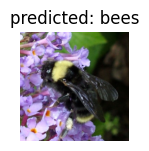

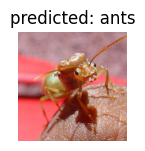

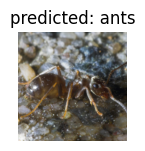

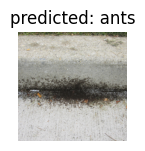

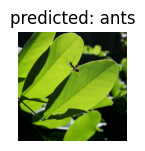

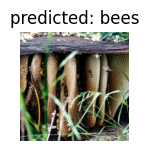

In [15]:
# =============================================================
# [셀 설명] Fine-tuning 결과 시각화
# -------------------------------------------------------------
# - 목적: Fine-tuning된 모델의 val 예측을 일부 이미지로 시각화합니다.
# - 입력: model_ft
# - 출력: 예측 시각화 플롯
# - 실행 전제: visualize_model 함수가 정의되어 있어야 합니다.
# - 주의: 데이터/모델 상태에 따라 예측 결과가 달라질 수 있습니다.
# - 권장 실행 순서: (8)
# =============================================================

visualize_model(model_ft)

In [10]:
# =============================================================
# [셀 설명] Feature Extraction(백본 고정) 모델 구성
# -------------------------------------------------------------
# - 목적: ResNet18의 백본 파라미터를 고정(freeze)하고, 마지막 FC 레이어만 학습하도록 설정합니다.
# - 입력: 사전학습 ResNet18; FC 교체(2클래스)
# - 출력: model_conv; optimizer_conv(FC만); scheduler
# - 실행 전제: device 설정 완료 필요
# - 주의: requires_grad=False로 백본을 고정하면 학습은 빨라지지만, 데이터가 ImageNet과 많이 다르면 성능이 제한될 수 있습니다.
# - 권장 실행 순서: (9)
# =============================================================

model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True 임
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 이전과는 다르게 마지막 계층의 매개변수들만 최적화되는지 관찰
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [11]:
# =============================================================
# [셀 설명] Feature Extraction 학습 실행
# -------------------------------------------------------------
# - 목적: train_model을 호출하여 마지막 FC만 학습합니다.
# - 입력: model_conv; criterion; optimizer_conv; scheduler
# - 출력: 학습된 model_conv
# - 실행 전제: train_model 함수가 정상 정의되어 있어야 합니다.
# - 주의: optimizer가 fc.parameters()만 받는지 확인해야 합니다(의도한 freeze인지 검증).
# - 권장 실행 순서: (10)
# =============================================================

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7632 Acc: 0.6066
val Loss: 0.5231 Acc: 0.7712

Epoch 1/24
----------
train Loss: 0.5624 Acc: 0.7582
val Loss: 0.1765 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.5678 Acc: 0.7500
val Loss: 0.2049 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.4839 Acc: 0.7869
val Loss: 0.1863 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.4689 Acc: 0.7828
val Loss: 0.1942 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.3264 Acc: 0.8484
val Loss: 0.2380 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.3351 Acc: 0.8525
val Loss: 0.1885 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3394 Acc: 0.8689
val Loss: 0.2012 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3116 Acc: 0.8730
val Loss: 0.1890 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3685 Acc: 0.8443
val Loss: 0.2332 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3043 Acc: 0.8648
val Loss: 0.1850 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.4052 Acc: 0.8443
val Loss: 0.2026 Acc: 0.9412

Ep

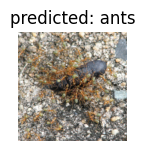

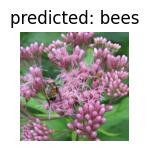

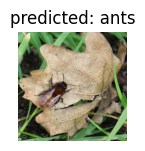

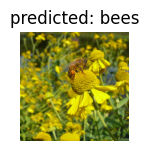

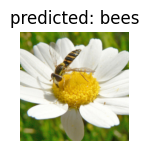

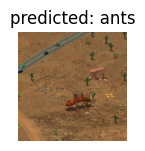

In [12]:
# =============================================================
# [셀 설명] Feature Extraction 결과 시각화
# -------------------------------------------------------------
# - 목적: Feature Extraction으로 학습된 모델의 예측을 시각화합니다.
# - 입력: model_conv
# - 출력: 예측 시각화 플롯
# - 실행 전제: visualize_model 함수 정의 필요
# - 주의: plt.ioff()/plt.show()는 대화형 모드 종료 및 최종 렌더링을 위해 사용합니다.
# - 권장 실행 순서: (11)
# =============================================================

visualize_model(model_conv)

plt.ioff()
plt.show()

In [16]:
# =============================================================
# [셀 설명] 단일 이미지 추론/시각화 함수 정의
# -------------------------------------------------------------
# - 목적: 이미지 파일 1장을 읽어 전처리 후 모델로 예측하고, 결과를 그림으로 표시합니다.
# - 입력: model; img_path; data_transforms['val']; class_names
# - 출력: 단일 이미지 예측 결과 플롯
# - 실행 전제: data_transforms, device, class_names가 정의되어 있어야 합니다.
# - 주의: img_path 경로가 정확해야 하며(Drive 마운트 여부 포함), 이미지가 손상되지 않아야 합니다.; unsqueeze(0)로 배치 차원을 추가합니다(모델 입력은 배치 단위를 기대).
# - 권장 실행 순서: (12)
# =============================================================

def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

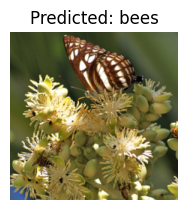

In [17]:
# =============================================================
# [셀 설명] 단일 이미지 예측 실행(예시)
# -------------------------------------------------------------
# - 목적: visualize_model_predictions를 호출하여 지정한 이미지에 대한 예측을 확인합니다.
# - 입력: img_path(예시 경로)
# - 출력: 예측 시각화 플롯
# - 실행 전제: Drive 마운트 및 해당 경로에 이미지가 존재해야 합니다.
# - 주의: 경로가 개인 환경에 종속되어 있으므로, 제출/공유 시에는 상대경로 또는 업로드 방식으로 바꾸는 것을 권장합니다.
# - 권장 실행 순서: (13)
# =============================================================

visualize_model_predictions(
    model_conv,
    img_path='/content/drive/MyDrive/0-ㄱ-CODEIT(2025)/deep/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

In [14]:
# =============================================================
# [셀 설명] 추가 실험/메모 영역
# -------------------------------------------------------------
# - 목적: 필요한 실험 코드, 결과 메모, 추가 그래프 등을 작성하는 공간입니다.
# - 입력: (자유)
# - 출력: (자유)
# - 실행 전제: 앞선 셀에서 생성된 변수/모델을 활용 가능
# - 주의: 재현성을 위해 변경 사항(파라미터/버전)을 함께 기록하세요.
# - 권장 실행 순서: (선택)
# =============================================================

# TODO: 여기에 추가 실험 코드를 작성하세요.


In [14]:
# =============================================================
# [셀 설명] 추가 실험/메모 영역
# -------------------------------------------------------------
# - 목적: 필요한 실험 코드, 결과 메모, 추가 그래프 등을 작성하는 공간입니다.
# - 입력: (자유)
# - 출력: (자유)
# - 실행 전제: 앞선 셀에서 생성된 변수/모델을 활용 가능
# - 주의: 재현성을 위해 변경 사항(파라미터/버전)을 함께 기록하세요.
# - 권장 실행 순서: (선택)
# =============================================================

# TODO: 여기에 추가 실험 코드를 작성하세요.


In [14]:
# =============================================================
# [셀 설명] 추가 실험/메모 영역
# -------------------------------------------------------------
# - 목적: 필요한 실험 코드, 결과 메모, 추가 그래프 등을 작성하는 공간입니다.
# - 입력: (자유)
# - 출력: (자유)
# - 실행 전제: 앞선 셀에서 생성된 변수/모델을 활용 가능
# - 주의: 재현성을 위해 변경 사항(파라미터/버전)을 함께 기록하세요.
# - 권장 실행 순서: (선택)
# =============================================================

# TODO: 여기에 추가 실험 코드를 작성하세요.


In [14]:
# =============================================================
# [셀 설명] 추가 실험/메모 영역
# -------------------------------------------------------------
# - 목적: 필요한 실험 코드, 결과 메모, 추가 그래프 등을 작성하는 공간입니다.
# - 입력: (자유)
# - 출력: (자유)
# - 실행 전제: 앞선 셀에서 생성된 변수/모델을 활용 가능
# - 주의: 재현성을 위해 변경 사항(파라미터/버전)을 함께 기록하세요.
# - 권장 실행 순서: (선택)
# =============================================================

# TODO: 여기에 추가 실험 코드를 작성하세요.


In [14]:
# =============================================================
# [셀 설명] 추가 실험/메모 영역
# -------------------------------------------------------------
# - 목적: 필요한 실험 코드, 결과 메모, 추가 그래프 등을 작성하는 공간입니다.
# - 입력: (자유)
# - 출력: (자유)
# - 실행 전제: 앞선 셀에서 생성된 변수/모델을 활용 가능
# - 주의: 재현성을 위해 변경 사항(파라미터/버전)을 함께 기록하세요.
# - 권장 실행 순서: (선택)
# =============================================================

# TODO: 여기에 추가 실험 코드를 작성하세요.


In [14]:
# =============================================================
# [셀 설명] 추가 실험/메모 영역
# -------------------------------------------------------------
# - 목적: 필요한 실험 코드, 결과 메모, 추가 그래프 등을 작성하는 공간입니다.
# - 입력: (자유)
# - 출력: (자유)
# - 실행 전제: 앞선 셀에서 생성된 변수/모델을 활용 가능
# - 주의: 재현성을 위해 변경 사항(파라미터/버전)을 함께 기록하세요.
# - 권장 실행 순서: (선택)
# =============================================================

# TODO: 여기에 추가 실험 코드를 작성하세요.
